<a href="https://www.kaggle.com/code/yusefsavid/titanic-1?scriptVersionId=117944729" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.display import display_markdown
import os
display_markdown(f'''# Welcome to my {os.getenv('PYTHONPATH').split('/')[-1]} competition notebook
''', raw=True)

# Welcome to my titanic competition notebook


# Install or update any packages needed

In [2]:
# !pip install headjackai-sdk
# !pip install --ignore-installed --pre pycaret

# Importing all that is needed

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc

from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder
from sklearn.utils import shuffle
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split,HalvingGridSearchCV
from sklearn.metrics import log_loss,accuracy_score,classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.experimental import enable_halving_search_cv 
import optuna
import xgboost as xgb
from tqdm.notebook import tqdm
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score,StratifiedKFold

pd.set_option('display.max_columns', None)   

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
# from pycaret.classification  import *
import os

INPUT = f"/kaggle/input/{os.getenv('PYTHONPATH').split('/')[-1]}/"
OUTPUT = "/kaggle/working/"


# Reading all datasets and some light analysis

In [4]:
train =  pd.read_csv(f"{INPUT}/train.csv")#.sample(frac=1).reset_index(drop=True)
test = pd.read_csv(f"{INPUT}/test.csv")#.sample(frac=1).reset_index(drop=True)
sample = pd.read_csv(f"{INPUT}/gender_submission.csv")
traintest = pd.concat([train,test], axis = 0).reset_index(drop=True)

In [5]:
traintest

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
traintest.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [7]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [8]:
traintest.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [9]:
sample 

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# EDA

## split columns that could be useful split

In [10]:
# splitable = ["Name" ,"Ticket"]
# delimeters = ["_" , "/" , "-"," ", '.' , ","]
# # traintest = pd.concat([train,test], axis = 0).sample(frac=1).reset_index(drop=True)
# for j,i in enumerate(splitable):
#     traintest = pd.concat([traintest,traintest[i].str.split("|".join(delimeters),expand=True).add_prefix(f'{i}_')], axis = 1)
# #     test = pd.concat([test,test[i].str.split(delimeters[j],expand=True).add_prefix(f'{i}_')], axis = 1) 
# #     traintest.drop(i, axis= 1, inplace = True)
# #     test.drop(i, axis= 1, inplace = True)
# # traintest[list(set(traintest.columns) - set(["Transported"])) ] = traintest[list(set(traintest.columns) - set(["Transported"])) ].fillna(method = "bfill")

In [11]:
traintest["title"] = traintest["Name"].str.split(" " , expand = True).iloc[:,1]
traintest["Ticket_1"] = traintest["Ticket"].str.split(" " , expand = True).iloc[:,0]
traintest["Ticket_2"] = traintest["Ticket"].str.split(" " , expand = True).iloc[:,1]
traintest.drop(["Ticket" , "Name"] ,axis = 1 , inplace = True)

In [12]:
traintest.loc[traintest.Ticket_2.isnull() , "ticket2_null"] = 1
traintest.loc[traintest.Ticket_2.isnull() ==False, "ticket2_null"] = 0
traintest.loc[traintest.ticket2_null == 1.0 , "Ticket_2"] = traintest.loc[traintest.ticket2_null == 1.0 , "Ticket_1"]
traintest.loc[traintest.ticket2_null == 1.0 , "Ticket_1"] = "Absent"

In [13]:
traintest.Ticket_1.value_counts()

Absent        961
PC             92
C.A.           46
SOTON/O.Q.     16
W./C.          14
STON/O         14
CA.            12
A/5            12
SC/PARIS       11
CA             10
A/5.           10
F.C.C.          9
SOTON/OQ        8
C               8
S.O.C.          7
S.O./P.P.       7
STON/O2.        7
A/4             6
SC/Paris        5
SC/AH           5
PP              4
SOTON/O2        3
A.5.            3
S.C./PARIS      3
F.C.            3
A/4.            3
A./5.           3
W.E.P.          2
P/PP            2
SC              2
WE/P            2
STON/OQ.        1
AQ/4            1
SC/A.3          1
C.A./SOTON      1
A.              1
LP              1
SC/A4           1
Fa              1
S.W./PP         1
A/S             1
SCO/W           1
SW/PP           1
W/C             1
S.O.P.          1
A4.             1
SO/C            1
S.P.            1
S.C./A.4.       1
AQ/3.           1
Name: Ticket_1, dtype: int64

In [14]:
traintest

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,title,Ticket_1,Ticket_2,ticket2_null
0,1,0.0,3,male,22.0,1,0,7.2500,NaN,S,Mr.,A/5,21171,0.0
1,2,1.0,1,female,38.0,1,0,71.2833,C85,C,Mrs.,PC,17599,0.0
2,3,1.0,3,female,26.0,0,0,7.9250,NaN,S,Miss.,STON/O2.,3101282,0.0
3,4,1.0,1,female,35.0,1,0,53.1000,C123,S,Mrs.,Absent,113803,1.0
4,5,0.0,3,male,35.0,0,0,8.0500,NaN,S,Mr.,Absent,373450,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,male,NaN,0,0,8.0500,NaN,S,Mr.,A.5.,3236,0.0
1305,1306,NaN,1,female,39.0,0,0,108.9000,C105,C,y,PC,17758,0.0
1306,1307,NaN,3,male,38.5,0,0,7.2500,NaN,S,Mr.,SOTON/O.Q.,3101262,0.0
1307,1308,NaN,3,male,NaN,0,0,8.0500,NaN,S,Mr.,Absent,359309,1.0


In [15]:
traintest["Cabin_1"]  = traintest.Cabin.str.get(0)


In [16]:
def process_cabin(x):
    if x != np.nan:
        return len(x.split())

In [17]:
traintest.Cabin


0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1304     NaN
1305    C105
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object

In [18]:
traintest[traintest["Cabin"].notnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,title,Ticket_1,Ticket_2,ticket2_null,Cabin_1
1,2,1.0,1,female,38.0,1,0,71.2833,C85,C,Mrs.,PC,17599,0.0,C
3,4,1.0,1,female,35.0,1,0,53.1000,C123,S,Mrs.,Absent,113803,1.0,C
6,7,0.0,1,male,54.0,0,0,51.8625,E46,S,Mr.,Absent,17463,1.0,E
10,11,1.0,3,female,4.0,1,1,16.7000,G6,S,Miss.,PP,9549,0.0,G
11,12,1.0,1,female,58.0,0,0,26.5500,C103,S,Miss.,Absent,113783,1.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,1296,NaN,1,male,43.0,1,0,27.7208,D40,C,Mr.,Absent,17765,1.0,D
1296,1297,NaN,2,male,20.0,0,0,13.8625,D38,C,Mr.,SC/PARIS,2166,0.0,D
1298,1299,NaN,1,male,50.0,1,1,211.5000,C80,C,Mr.,Absent,113503,1.0,C
1302,1303,NaN,1,female,37.0,1,0,90.0000,C78,Q,Mrs.,Absent,19928,1.0,C


In [19]:
traintest["no_cabins"] = traintest[traintest["Cabin"].notnull()].Cabin.apply(lambda x:  len(x.split()))

In [20]:
traintest.Ticket_1.unique()

array(['A/5', 'PC', 'STON/O2.', 'Absent', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON', 'SC/A.3', 'STON/OQ.', 'SC/A4', 'AQ/4', 'A.', 'LP',
       'AQ/3.'], dtype=object)

## Create new columns 

In [21]:
# def cryosleep_nan(row):
#     if row['Expenses'] == 0.0:
#         return True
#     else: 
#         return False

# traintest.loc[traintest["CryoSleep"].isnull() == True , "CryoSleep"] = traintest.apply(lambda row:cryosleep_nan(row), axis=1 )
# traintest.loc[(traintest["Expenses"]== 0.0)&(traintest["Age"].isnull()) , "Age"] = traintest.query('CryoSleep == False and Expenses == 0.0').Age.median()
# traintest.loc[(traintest["Expenses"] > 0.0) &(traintest["Age"].isnull())  ,"Age"] = traintest.query('Expenses > 0.0').Age.median()
# traintest.loc[(traintest["Expenses"]<1400)&(traintest["Age"]<37)&(traintest["VIP"].isnull())  , "VIP"] = False
# traintest.loc[traintest["VIP"].isnull() , "VIP"] = True
# traintest.loc[traintest["HomePlanet"].isnull(), "HomePlanet"] = traintest.Cabin_0.map(mapper_homeplant)
# traintest["cabin_count"] = traintest.Cabin_1.map(traintest.groupby("Cabin_1")["Cabin_1"].count())
# traintest["passengerId_count"] = traintest.PassengerId_0.map(traintest.groupby("PassengerId_0")["PassengerId_0"].count() ) 
# traintest.loc[traintest.Expenses == 0.0, "did_spend"]  = False
# traintest.loc[traintest.Expenses > 0.0 , "did_spend"] = True 
# traintest.loc[traintest.Age == 0.0 , "age_zero"] = True
# traintest.loc[traintest.Age > 0.0 , "age_zero"] = False
# traintest.loc[traintest.Age <13.0 , "is_minor"] = True
# traintest.loc[traintest.Age >= 13.0, "is_minor"] = False 
# traintest["age_bin"] = pd.cut(traintest["Age"], bins=10, labels=False)
# # traintest.loc[(traintest["Age"] == 0.0) & (traintest["Expenses"] == 0.0) ,"Age"] = traintest.query('CryoSleep == False and Expenses == 0.0').Age.median()


In [22]:
traintest

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,title,Ticket_1,Ticket_2,ticket2_null,Cabin_1,no_cabins
0,1,0.0,3,male,22.0,1,0,7.2500,NaN,S,Mr.,A/5,21171,0.0,NaN,NaN
1,2,1.0,1,female,38.0,1,0,71.2833,C85,C,Mrs.,PC,17599,0.0,C,1.0
2,3,1.0,3,female,26.0,0,0,7.9250,NaN,S,Miss.,STON/O2.,3101282,0.0,NaN,NaN
3,4,1.0,1,female,35.0,1,0,53.1000,C123,S,Mrs.,Absent,113803,1.0,C,1.0
4,5,0.0,3,male,35.0,0,0,8.0500,NaN,S,Mr.,Absent,373450,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,male,NaN,0,0,8.0500,NaN,S,Mr.,A.5.,3236,0.0,NaN,NaN
1305,1306,NaN,1,female,39.0,0,0,108.9000,C105,C,y,PC,17758,0.0,C,1.0
1306,1307,NaN,3,male,38.5,0,0,7.2500,NaN,S,Mr.,SOTON/O.Q.,3101262,0.0,NaN,NaN
1307,1308,NaN,3,male,NaN,0,0,8.0500,NaN,S,Mr.,Absent,359309,1.0,NaN,NaN


In [23]:
# features = test.columns ### For now assuming all column names other than the target are features
target = "Survived" ### Change to the column name of the target variable
numeric_features = ["PassengerId", 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare' ,"ticket2_null" , "no_cabins"  ] ### Add all numeric features
categorical_features = ["Sex" , "Cabin" ,"Embarked" ,"title","Ticket_1" ,"Cabin_1" ]
# traintest[numeric_features] = traintest[numeric_features].astype("float")

<AxesSubplot:>

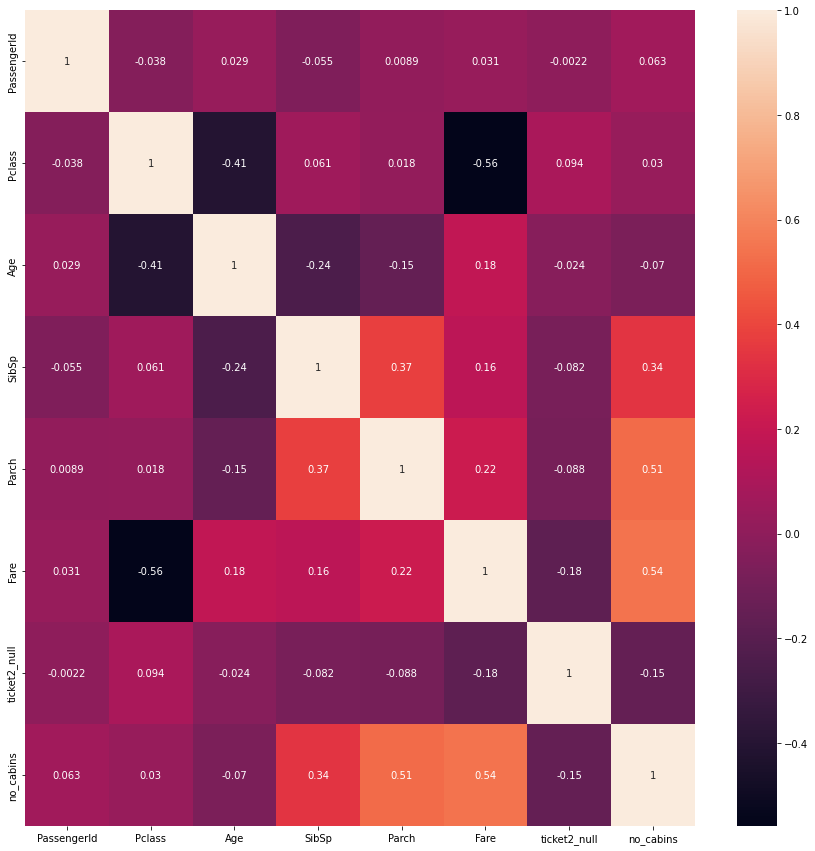

In [24]:
plt.figure(figsize = (15,15))
sns.heatmap(traintest[numeric_features].corr(),annot = True) ### check for any high values, will be addressed later

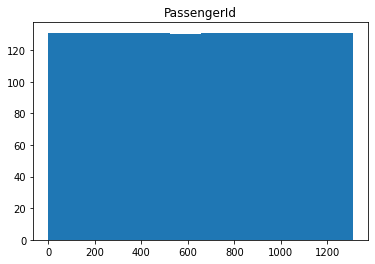

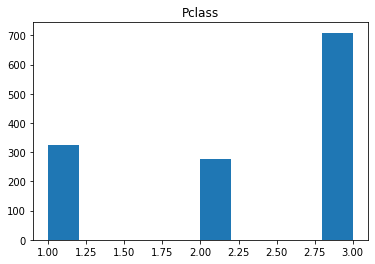

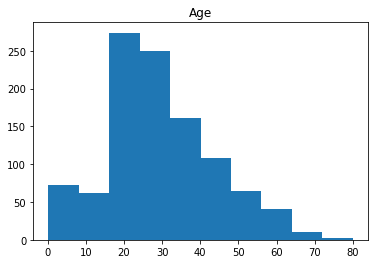

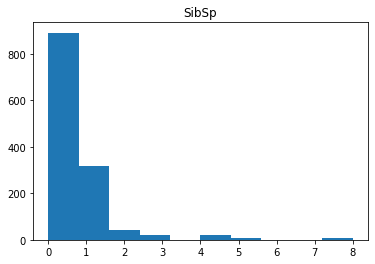

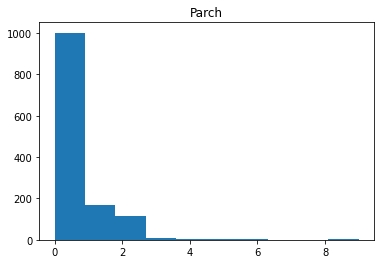

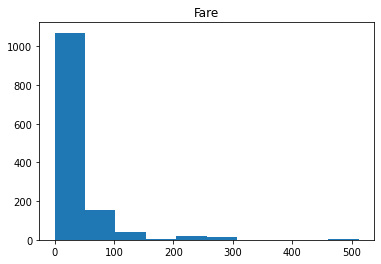

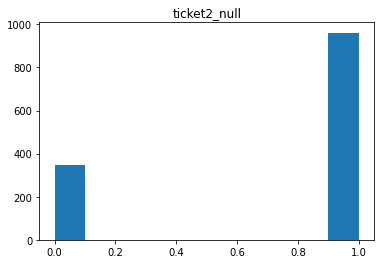

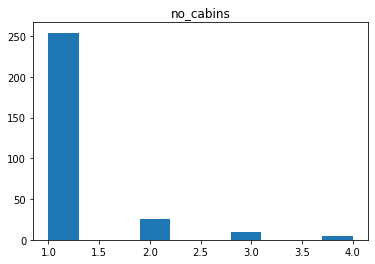

In [25]:
for i in numeric_features: ### Check for skwenness 
    plt.title(f"{i}")
    plt.hist(traintest[f"{i}"])
    plt.show()
# remove_skewness =[ 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , "Expenses" ]

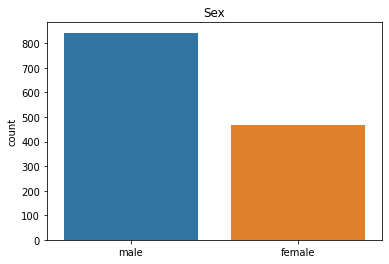

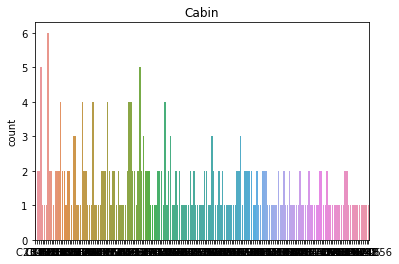

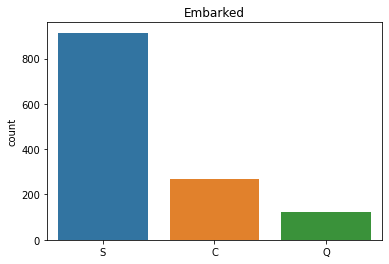

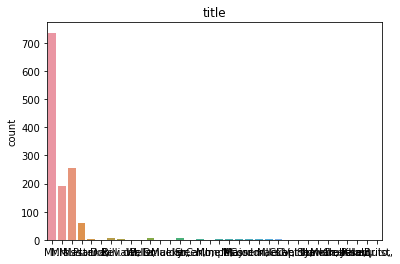

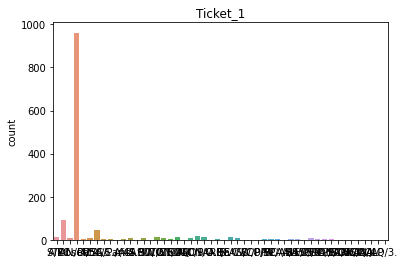

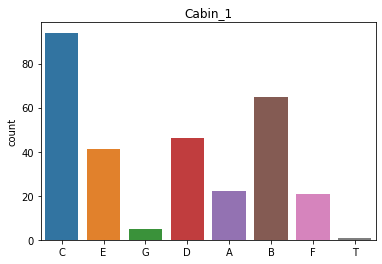

In [26]:
for i in list(categorical_features):
    plt.title(i)
    sns.countplot(x = traintest[f"{i}"].values)
    plt.show()

# Time to work on the data!!

### Fix skeweness of numeric data

In [27]:
# for i in remove_skewness:
#     traintest[i] = np.sqrt(traintest[i])

In [28]:
# for i in numeric_features: ### Check for skwenness 
#     plt.title(f"{i}")
#     plt.hist(traintest[f"{i}"])
#     plt.show()
# remove_skewness =[ 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , "Expenses" ]

In [29]:
## check if target is skewed

In [30]:
# imputer = SimpleImputer(strategy = "mean")
# traintest.loc[:,numeric_features] = imputer.fit_transform(traintest.loc[:,numeric_features].values)
# # test.loc[:,numeric_features] = imputer.transform(test.loc[:,numeric_features].values)
# imputer = SimpleImputer(strategy = "most_frequent")
# traintest.loc[:,categorical_features] = imputer.fit_transform(traintest.loc[:,categorical_features].values)
# # test.loc[:,categorical_features]= imputer.fit_transform(test.loc[:,categorical_features].values)

### Check colinearity 

In [31]:
# #check colinearity
# #Compute VIF data for each independent variable
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = pd.DataFrame()
# vif["features"] = traintest[numeric_features].columns
# vif["vif_Factor"] = [variance_inflation_factor(traintest[numeric_features].values, i) for i in range(traintest[numeric_features].shape[1])]
# vif
# #>10 not so good

In [32]:
# #feature engineer
# from headjackai.headjackai_hub import headjackai_hub

# #host setting
# hj_hub = headjackai_hub('http://www.headjackai.com:9000')
# hj_hub.login(username='jimliu_kaggle', pwd='12345678')
# hj_hub.knowledgepool_check(public_pool=True)
# source = 'drug_type'


# best_features = [
#  'Spaceship-Titanic-CryoSleep',
#  'Spaceship-Titanic-RoomService',
#  'Spaceship-Titanic-Spa',
#  'Spaceship-Titanic-VRDeck',
#  'Spaceship-Titanic-deck',
#  'Spaceship-Titanic-side',
#  'Spaceship-Titanic-SumSpends',
#  'drug_type-Sex']


# # run features engineering on hj 
# hj_X = hj_hub.knowledge_transform(data=train, target_domain='Spaceship-Titanic', 
#                                   source_domain=source,
#                                   label='')

# hj_ts_X = hj_hub.knowledge_transform(data=test, target_domain='Spaceship-Titanic', 
#                                   source_domain=source,
#                                   label='') 

# Encode, impute missing values and scale

In [33]:
print(traintest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Survived      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Sex           1309 non-null   object 
 4   Age           1046 non-null   float64
 5   SibSp         1309 non-null   int64  
 6   Parch         1309 non-null   int64  
 7   Fare          1308 non-null   float64
 8   Cabin         295 non-null    object 
 9   Embarked      1307 non-null   object 
 10  title         1309 non-null   object 
 11  Ticket_1      1309 non-null   object 
 12  Ticket_2      1309 non-null   object 
 13  ticket2_null  1309 non-null   float64
 14  Cabin_1       295 non-null    object 
 15  no_cabins     295 non-null    float64
dtypes: float64(5), int64(4), object(7)
memory usage: 163.8+ KB
None


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
labenc = LabelEncoder()
labenc.fit(traintest.loc[traintest[target].isnull() == False ,target].unique())

traintest.loc[traintest[target].isnull() == False ,target] = \
labenc.transform(traintest.loc[traintest[target].isnull() == False ,target])

new_cats = pd.get_dummies(traintest[categorical_features]).columns
traintest = pd.concat([pd.get_dummies(traintest[categorical_features]) , traintest] , axis = 1)
traintest.drop(list(set(categorical_features) ) , axis= 1 , inplace = True)
categorical_features = list(new_cats.copy())
imputer = KNNImputer()
traintest[numeric_features+categorical_features] = imputer.fit_transform(traintest[numeric_features+categorical_features].values)
scaler = StandardScaler()
traintest[numeric_features+categorical_features] = scaler.fit_transform(traintest[numeric_features+categorical_features].values)

# Time for some ML

In [35]:
# features_isolation =numeric_features+categorical_features
# from sklearn.ensemble import IsolationForest

# isf = IsolationForest(n_jobs=-1, random_state=1,n_estimators=100,contamination=0.002)
# isf.fit(traintest.loc[features_isolation], traintest[target])

# rows = pd.DataFrame(isf.predict(traintest[features_isolation]),columns=['feature'])
# rows_ind = rows[rows.feature == 1]
# results = pd.DataFrame()
# results['results'] = - isf.score_samples(traintest[features_isolation])
# results['chance'] = isf.decision_function(traintest[features_isolation])
# results['yes/no'] = isf.predict(traintest[features_isolation])

# new = results[results['yes/no']==1]
# old= results[results['yes/no']==-1]
# fig,ax = plt.subplots(figsize=(20,10))
# ax.set_facecolor('black')
# ax = plt.scatter(new.index,new.results,marker=".")
# ax = plt.scatter(old.index,old.results,color='white',marker="*")

## split into features and targets for the models

In [36]:
x = traintest.loc[traintest[target].isnull() == False  , numeric_features +categorical_features].values
y = traintest.loc[traintest[target].isnull() == False  , target].values
x_test = traintest.loc[traintest[target].isnull() == True  , numeric_features +categorical_features].values
y=y.astype('int')
x = x.astype("float64")
x_test = x_test.astype("float64")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Select all the models needed

In [37]:
import xgboost as xgb
params_XGB_best= {'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 725, #initial value is 651
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1}
classifiers = [

RandomForestClassifier(),
AdaBoostClassifier(),
GradientBoostingClassifier(),
ExtraTreesClassifier(),
LinearDiscriminantAnalysis(),
LogisticRegression(),
KNeighborsClassifier(),
DecisionTreeClassifier(),
MLPClassifier(),
CatBoostClassifier(verbose = False),
SVC()
]

## Running through all and cross validating  

In [38]:
model_results_columns = ['fit_time', 'score_time', 'test_accuracy', 'train_accuracy',
       'test_precision', 'train_precision', 'test_recall', 'train_recall',
       'test_r2', 'train_r2', 'test_neg_mean_squared_error',
       'train_neg_mean_squared_error']
model_results_df = pd.DataFrame([], columns = model_results_columns)
for clf in tqdm(classifiers):
    model = cross_validate(clf , x, y , cv= 10,\
                           scoring=('accuracy' , 'precision', 'recall' , 'r2', 'neg_mean_squared_error'),return_train_score=True)
    model_results_df = pd.concat([model_results_df,pd.DataFrame(pd.DataFrame(model).describe().loc["mean" ,:]).rename(columns = {"mean":str(clf).split("(")[0]}).transpose()], axis = 0)

  0%|          | 0/11 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

## Analyse results
For the **overfitting** column, the closer to zero the better

In [39]:
model_results_df["overfitting"] =(1-(model_results_df["test_accuracy"]/ model_results_df["train_accuracy"]))*100
model_results_df.sort_values("test_accuracy", ascending = False)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,overfitting
<catboost.core.CatBoostClassifier object at 0x7f215cd02190>,1.364435,0.011162,0.840624,0.919067,0.838212,0.922912,0.725126,0.861271,0.325952,0.657802,-0.159376,-0.080933,8.535064
GradientBoostingClassifier,0.256877,0.002526,0.836155,0.909341,0.836374,0.908076,0.713445,0.849904,0.307183,0.616679,-0.163845,-0.090659,8.048287
RandomForestClassifier,0.193952,0.013572,0.830537,0.999875,0.824035,1.000000,0.710420,0.999675,0.283538,0.999473,-0.169463,-0.000125,16.935960
KNeighborsClassifier,0.001280,0.007569,0.814844,0.861579,0.817781,0.853870,0.681345,0.771602,0.217159,0.414722,-0.185156,-0.138421,5.424354
ExtraTreesClassifier,0.208458,0.014467,0.812597,1.000000,0.788906,1.000000,0.698739,1.000000,0.207539,1.000000,-0.187403,0.000000,18.740325
LogisticRegression,0.029546,0.002492,0.811461,0.890136,0.755078,0.865089,0.754370,0.845678,0.202545,0.535470,-0.188539,-0.109864,8.838550
DecisionTreeClassifier,0.007704,0.002148,0.781174,1.000000,0.724528,1.000000,0.701933,1.000000,0.074630,1.000000,-0.218826,0.000000,21.882647
MLPClassifier,0.825762,0.002939,0.778876,0.900238,0.698183,0.893559,0.754286,0.841133,0.064826,0.578182,-0.221124,-0.099762,13.481013
AdaBoostClassifier,0.129252,0.009717,0.770275,0.858711,0.742956,0.829599,0.733361,0.795326,0.029104,0.402599,-0.229725,-0.141289,10.298705
SVC,0.041611,0.012277,0.758652,0.865446,0.655867,0.818237,0.789244,0.834968,-0.020692,0.431081,-0.241348,-0.134554,12.339779


## Combine models

In [40]:
# model = VotingClassifier([('cbc',CatBoostClassifier(verbose = False)) , ('svc',SVC()),('gbc',GradientBoostingClassifier())] , voting = "hard")

In [41]:

# re = cross_validate(model , x, y , cv= 10,\
#                            scoring=('accuracy' , 'precision', 'recall' , 'r2', 'neg_mean_squared_error'),return_train_score=True)

## Hyperparameter tuning

In [42]:
hp = {
    "criterion":['gini', 'entropy'],
    "splitter":["best" ,"random"],
    "min_samples_split":[1.0,2,3,4]
}
# hp = {
#     "hidden_layer_sizes":[50,100,200,300,1000],
#     "activation":['identity', 'logistic', 'tanh', 'relu'],
#     "solver":["lbfgs" , 'sgd','adam'],
#     "alpha":[0.0001,0.001,0.01,0.00001],
#     "learning_rate":["constant" , "invscaling" ,"adapting"],
#     "learning_rate_init":[0.1,0.01,0.001,0.0001],
#     "max_iter":[20000]
    
# }
params_RandomForestClassifier = {
    "n_estimators":[10,100,200,400],
#     "criterion":['gini', 'entropy'],
#     "max_depth":[100,10,None],
#     "max_features":["sqrt" , "log2" , None],
}
params_catboost = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }    

params_SVC = {
    'kernel':["linear" , "poly"  , "rbf" , "sigmoid" ],
    "degree" : [1,2,3,4],
    "gamma" : ["scale" ,"auto"],
    "probability":[True, False],
    "decision_function_shape":["ovo" ,"ovr"],
}


In [43]:
# from sklearn.experimental import enable_halving_search_cv 
# from sklearn.model_selection import HalvingGridSearchCV
# sh = HalvingGridSearchCV(model, params_catboost, cv=10,verbose = 2, scoring = "accuracy").fit(x, y)

In [44]:
# model = SVC()
# sh = HalvingGridSearchCV(model, params_SVC, cv=10,verbose = 2, scoring = "accuracy").fit(x, y)

# Choose the best model to fit and then predict on test

In [45]:
best_params = {'decision_function_shape': 'ovo',
 'degree': 4,
 'gamma': 'scale',
 'kernel': 'linear',
 'probability': True}

In [46]:
model = CatBoostClassifier(verbose = False)

In [47]:
# re = pd.DataFrame(cross_validate(model , x, y , cv= 10,\
#                            scoring=('accuracy' , 'precision', 'recall' , 'r2', 'neg_mean_squared_error'),return_train_score=True))

In [48]:
# re.mean()

In [49]:
model.fit(x,y)

In [50]:
preds = model.predict(x_test) 

In [51]:
pd.concat([test.reset_index() , pd.DataFrame(labenc.inverse_transform(preds), columns = [target])], axis = 1)[["PassengerId", target]]

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


# Download submission

In [52]:
pd.concat([test.reset_index() , pd.DataFrame(labenc.inverse_transform(preds), columns = [target])], axis = 1)[["PassengerId", target]].to_csv("submission.csv", index = False)